In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gseapy as gp
from gseapy import dotplot
import scanpy as sc
import scipy.sparse
from adjustText import adjust_text 
import warnings
import matplotlib.cm as cm
import pickle
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import anndata as ad
%matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2


# Gene Ontology

## Loadings

First, let's do GSEA on the PCA loadings and make sure PC1 is related to confluency. 

In [2]:
loadings_for_gsea_raw = pd.read_csv('./Data/loadings_for_gsea_raw_03052025.csv')
loadings_for_gsea_raw.columns = ["Gene", "Score"]


In [3]:
loadings_for_gsea_raw

,Gene,Score
0,KIF11,0.026652
1,FANCD2,0.026609
2,KIF2C,0.026530
3,DNAJC15,0.026448
4,DNA2,0.026407
...,...,...
9513,POR,-0.024078
9514,SPTBN1,-0.024102
9515,AIFM1-1,-0.024193
9516,GLUL,-0.025069


MSigDB_Hallmark_2020


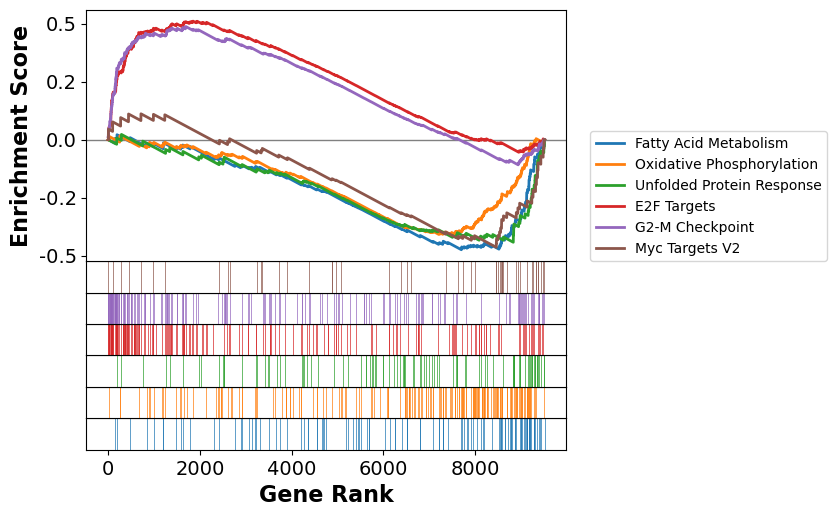

MSigDB_Hallmark_2020


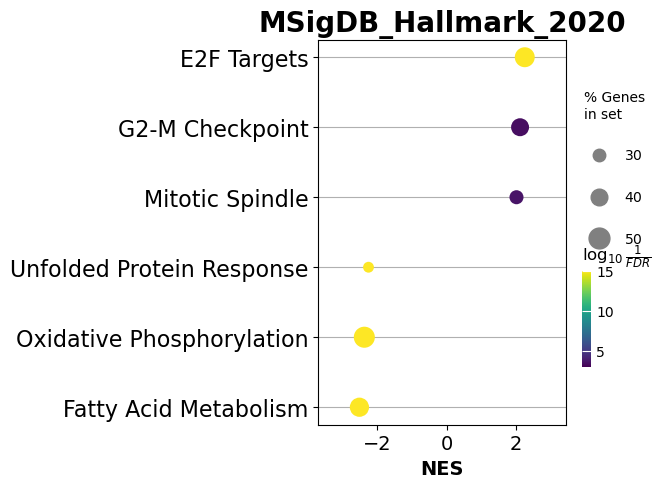

In [4]:
# Load your ranked genes (example format: gene_name, score)
loadings_for_gsea_raw = pd.read_csv('./Data/loadings_for_gsea_raw_03052025.csv')

loadings_for_gsea_raw.columns = ["Gene", "Score"]
dbs = ['MSigDB_Hallmark_2020',
       #'GO_Biological_Process_2023',
       #'Reactome_2022','Reactome_Pathways_2024',
       #'WikiPathways_2024_Human','GO_Cellular_Component_2023',
       #'GO_Molecular_Function_2023','KEGG_2021_Human'
      ]

for db in dbs:
# Run preranked GSEA
    prerank_res = gp.prerank(
        rnk=loadings_for_gsea_raw,  # DataFrame with gene rankings
        gene_sets=db,  # You can change this to another gene set
        #outdir="gsea_results",  # Output directory
        permutation_num=1000,  # Number of permutations (increase for robustness)
        seed=42
    )
    
    # View results
    #print(prerank_res.res2d)  # Summary of results
    print(db)
    terms = prerank_res.res2d.Term
    axs = prerank_res.plot(terms[:6], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )
    plt.show()
    # to save your figure, make sure that ``ofname`` is not None
    print(db)
    ax = dotplot(prerank_res.res2d,
                 column="FDR q-val",
                 title=db,
                 cmap=plt.cm.viridis,
                 size=5,
                 figsize=(4,5), top_term=6,cutoff=1)
    plt.show()

## DEA

Now, let's take the results of the DE proteins from our statistical tests, and see what biological terms are related to up- or down-regulated proteins.

In [5]:
def plot_volcano(model_results, term_filter, title, significance_threshold=0.01, coef_threshold=0,color1='cornflowerblue',color2='lightcoral'):
    """
    Generate a volcano plot from model results and return significant upregulated and downregulated proteins.
    
    Parameters:
    - model_results: dict, output from extract_model_results
    - term_filter: str, the specific coefficient term to plot (e.g., 'condition[T.N]')
    - title: str, title for the plot
    - significance_threshold: float, threshold for significance (default=0.1)
    - coef_threshold: float, absolute coefficient threshold for significance (default=0.5)
    
    Returns:
    - upregulated: list of significantly upregulated proteins
    - downregulated: list of significantly downregulated proteins
    """
    
    # Prepare data for plotting
    data = []
    for protein, results in model_results.items():
        if "coefficients" in results and "p-values" in results:
            coef_df = results["coefficients"]
            pval_df = results["p-values"]
            
            if term_filter in coef_df.index:
                coef = coef_df.loc[term_filter, "estimate"]
                pval = pval_df.loc[term_filter, "p_value_fdr"] if "p_value_fdr" in pval_df.columns else pval_df.loc[term_filter, "p_value"]
                
                data.append({"protein": protein, "coef": coef, "pval_corrected": pval})
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    if df.empty:
        print(f"⚠️ No data found for term '{term_filter}'")
        return [], []
    
    # Define x and y axes
    x = df['coef']  # Effect size (log2 fold change)
    y = -np.log10(df['pval_corrected'])  # Significance (-log10 adjusted p-value)
    
    # Define significance color mapping
    df['significant_up'] = (df['pval_corrected'] < significance_threshold) & (df['coef'] > coef_threshold)
    df['significant_down'] = (df['pval_corrected'] < significance_threshold) & (df['coef'] < -coef_threshold)
    
    # Extract lists of upregulated and downregulated proteins
    upregulated = df[df['significant_up']]['protein'].tolist()
    downregulated = df[df['significant_down']]['protein'].tolist()
    
    # Assign colors
    df['color'] = 'gray'  # Default non-significant
    df.loc[df['significant_up'], 'color'] = color1
    df.loc[df['significant_down'], 'color'] = color2
    
    # Plot
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(
        x=x, y=y, hue=df['color'], palette={color1: color1, color2: color2, "gray": 'gray'}, alpha=0.7, edgecolor=None
    )
    
    # Label only the ten most significant proteins
    top_significant = df.nsmallest(6, 'pval_corrected')
    for i, row in top_significant.iterrows():
        plt.text(row['coef'], -np.log10(row['pval_corrected']), row['protein'], fontsize=12, alpha=0.8)
    
    # Add threshold lines
    plt.axhline(-np.log10(significance_threshold), linestyle='dotted', color='black', alpha=0.6)  # Significance threshold line
    #plt.axvline(coef_threshold, linestyle='dashed', color='black', alpha=0.6)  # Positive coefficient threshold
    #plt.axvline(-coef_threshold, linestyle='dashed', color='black', alpha=0.6)  # Negative coefficient threshold

    plt.ylim([0,25])
    plt.xlim([-1.6,1.6])
    # Labels and title
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(f"{title} Effect Size (Coef)",fontsize=20)
    plt.ylabel("-log10 Adjusted P-value",fontsize=20)
    #plt.title(f"Volcano Plot: {title}")
    
    # Correct legend
    handles, labels = scatter.get_legend_handles_labels()
    color_mapping = {color1: "Upregulated", color2: "Downregulated", 
                     "gray": "Non-significant"}
    new_labels = [(color_mapping[label]+' in '+title) if label in color_mapping else label for label in labels]
    plt.legend(handles=handles, labels=new_labels, fontsize=12)
    
    plt.show()
    
    return df, upregulated, downregulated

# Example usage:
# upregulated, downregulated = plot_volcano(model_results, 'condition[T.N]', 'A vs N', significance_threshold=0.05, coef_threshold=0.5)


In [6]:
with open("./Data/lme3_extracted_results_03032025.pkl", "rb") as f:
    lme3_extracted_results = pickle.load(f)

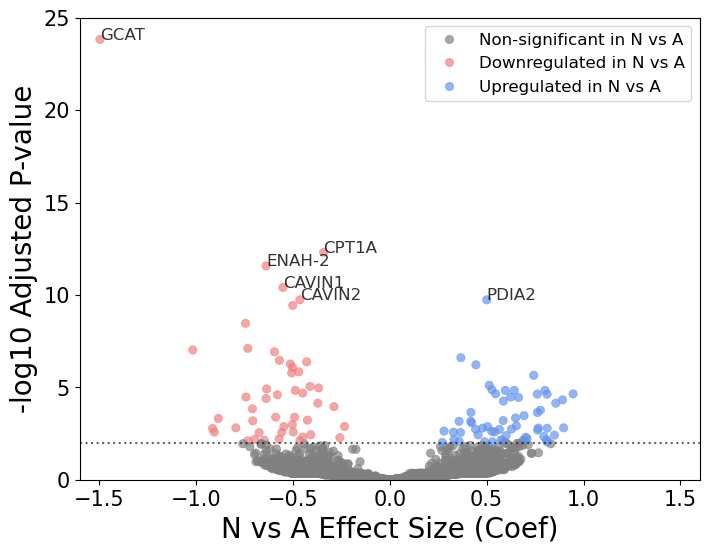

In [7]:
lme3_N_df, lme3_upregulated_condN, lme3_downregulated_condN = plot_volcano(lme3_extracted_results, 'condition[T.N]', 'N vs A')

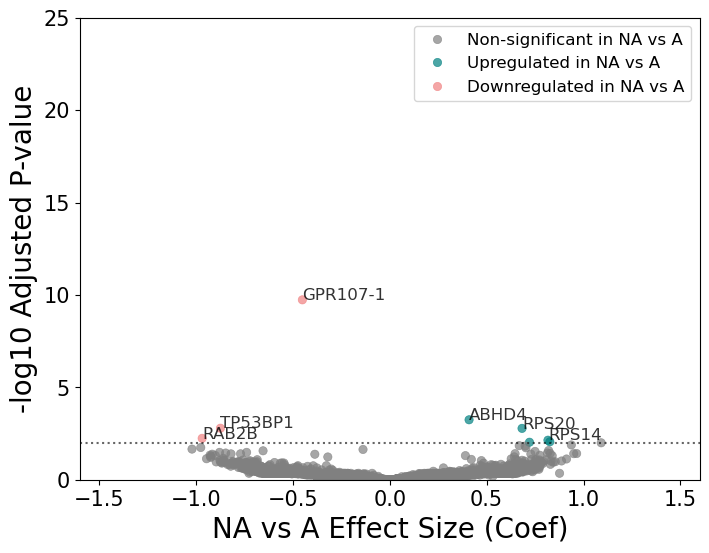

In [8]:
lme3_NA_df,lme3_upregulated_condNA, lme3_downregulated_condNA = plot_volcano(lme3_extracted_results, 'condition[T.NA]', 'NA vs A',color1='teal')

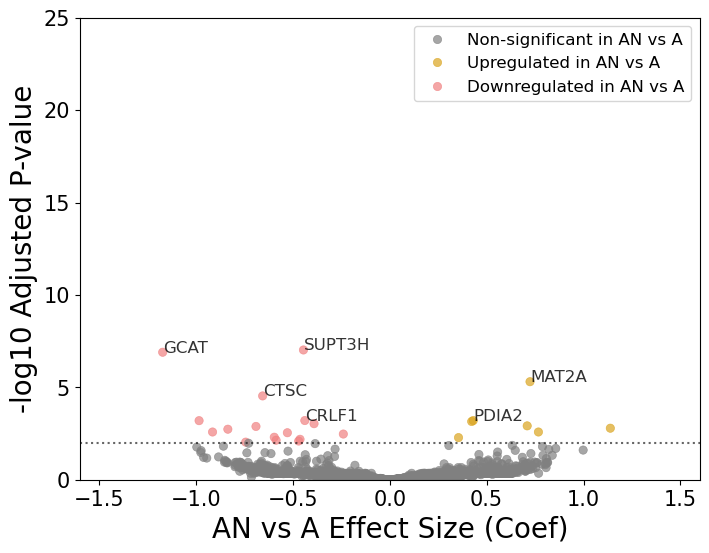

In [9]:
lme3_AN_df,lme3_upregulated_condAN, lme3_downregulated_condAN = plot_volcano(lme3_extracted_results, 'condition[T.AN]', 'AN vs A',color1='goldenrod')

In [10]:
# Write to Excel with multiple sheets
with pd.ExcelWriter('./Data/lme3_de_results.xlsx') as writer:
    lme3_N_df.to_excel(writer, sheet_name='NvA', index=False)
    lme3_NA_df.to_excel(writer, sheet_name='NAvA', index=False)
    lme3_AN_df.to_excel(writer, sheet_name='ANvA', index=False)

In [11]:
len1=len(lme3_upregulated_condN)
len2=len(lme3_downregulated_condN)
print(len1, len2, len1+len2)

59 49 108


In [12]:
len1=len(lme3_upregulated_condNA)
len2=len(lme3_downregulated_condNA)
print(len1, len2, len1+len2)

5 3 8


In [13]:
len1=len(lme3_upregulated_condAN)
len2=len(lme3_downregulated_condAN)
print(len1, len2, len1+len2)

7 16 23


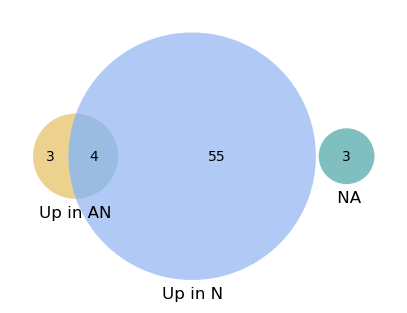

In [14]:
# Convert lists to sets
up_set1 = set(lme3_upregulated_condN)
up_set2 = set(lme3_upregulated_condAN)
up_set3 = set(lme3_downregulated_condNA)

# Create Venn diagram
plt.figure(figsize=(5, 5))
venn = venn3([up_set3,up_set2,up_set1], set_labels=(' NA','Up in AN', 'Up in N'))

# Change the colors of the circles
colors = ['teal', 'goldenrod', 'lightblue','cornflowerblue']  # Set your desired colors here
for patch, color in zip(venn.patches[:4], colors):
    if patch:
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

plt.show()

In [15]:
up_set3

{'GPR107-1', 'RAB2B', 'TP53BP1'}

In [16]:
always_up_and_sig=up_set1 & up_set2
always_up_and_sig

{'FAM3C', 'MAT2A', 'MTDH-2', 'PDIA2'}

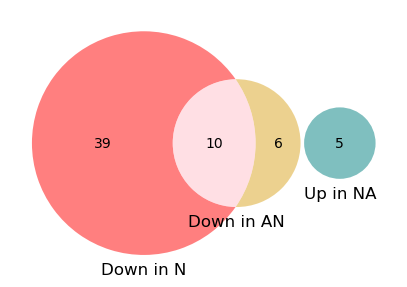

In [17]:
# Convert lists to sets
down_set1 = set(lme3_downregulated_condN)
down_set2 = set(lme3_downregulated_condAN)
down_set3 = set(lme3_upregulated_condNA)

# Create Venn diagram
plt.figure(figsize=(5,5))
#venn=venn3([down_set3,down_set2,down_set1], set_labels=('Up in NA','Down in AN','Down in N',))
venn=venn3([down_set1,down_set2,down_set3], set_labels=('Down in N','Down in AN','Up in NA'))

       # Change the colors of the circles
colors = ['red', 'goldenrod', 'pink','teal','coral','orangered']  # Set your desired colors here
for patch, color in zip(venn.patches[:6], colors):
    if patch:
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

plt.show()

In [18]:
down_set3

{'ABHD4', 'HPD', 'RPS14', 'RPS20', 'TP53RK'}

In [19]:
always_down_and_sig=down_set1 & down_set2
always_down_and_sig

{'CAVIN2',
 'CPT1A',
 'CRLF1',
 'CTSC',
 'GCAT',
 'HEXB-1',
 'MTUS1',
 'PLA2G15',
 'SEMA3B',
 'STEAP3'}

In [20]:
always_up_in_NvA=set(lme3_upregulated_condN+lme3_upregulated_condAN+lme3_downregulated_condNA)
print(len(always_up_in_NvA))
always_up_in_NvA

65


{'AASS',
 'ACACA',
 'AK1',
 'AKR1B10',
 'ALCAM',
 'ALDH18A1',
 'ALDH1L2',
 'AMPD2',
 'ANPEP',
 'APOE',
 'ATP6V0A1',
 'CES1',
 'CLU',
 'CMBL',
 'DDX52',
 'DDX54-1',
 'DSG2',
 'EDEM3',
 'FAM3C',
 'FDPS',
 'GFPT1',
 'GPHN',
 'GPR107-1',
 'HYOU1-1',
 'ILF3',
 'ITIH2',
 'ITPRID2',
 'JUP',
 'KDM4A',
 'MAT2A',
 'MESD',
 'MTDH-2',
 'MTTP',
 'MYO1A-1',
 'MYO1D',
 'NDUFA12',
 'NDUFA13',
 'NIFK',
 'NOP56',
 'P4HB-3',
 'PDIA2',
 'PKLR-1',
 'PPIB',
 'RAB2B',
 'RBM28-1',
 'RNF149',
 'RPF2',
 'RRP1',
 'RRP9',
 'SEC11C',
 'SFXN3',
 'SLCO4C1',
 'SORD',
 'SRFBP1',
 'SRPRB-1',
 'SRSF9',
 'SUPT5H-1',
 'SUPT6H',
 'TKFC',
 'TP53BP1',
 'UGT2B7',
 'UTP15',
 'VCP-3',
 'WDR3',
 'WDR36'}

In [21]:
always_down_in_NvA=set(lme3_downregulated_condN+lme3_downregulated_condAN+lme3_upregulated_condNA)
print(len(always_down_in_NvA))
always_down_in_NvA

60


{'ABHD4',
 'ADCY9',
 'ANXA3',
 'ARHGAP29',
 'CAVIN1',
 'CAVIN2',
 'CHST3',
 'CISD1',
 'CPQ',
 'CPT1A',
 'CPVL',
 'CRIP2',
 'CRLF1',
 'CTSC',
 'CTSD-1',
 'CTSH',
 'CTSL',
 'ENAH-2',
 'FAM107B',
 'FSCN1',
 'FUCA2',
 'GCAT',
 'GNS',
 'HEXA',
 'HEXB',
 'HEXB-1',
 'HPD',
 'HSPB1',
 'IL18',
 'KRT19-1',
 'KRT23',
 'LRRC20',
 'MANBA',
 'MTUS1',
 'NAGA',
 'NAGLU',
 'NME4',
 'NOTUM',
 'NR3C1',
 'PET100',
 'PFKP',
 'PHACTR2-1',
 'PLA2G15',
 'PPIP5K1',
 'PPP1R2',
 'RABEP1',
 'RB1',
 'RIF1',
 'RPS14',
 'RPS20',
 'SEMA3B',
 'SLC3A2',
 'SMPD1',
 'STEAP3',
 'SUPT3H',
 'TAGLN2',
 'TATDN2',
 'TGM2',
 'TP53RK',
 'TPM1-1'}

In [22]:
for prot in always_down_in_NvA:
    if prot in always_up_in_NvA:
        print(prot)

In [23]:
# List available gene sets from Enrichr
available_gene_sets = gp.get_library_name(organism="Human")
print(available_gene_sets)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_C

In [24]:
def remove_dash_number(strings):
    """
    Removes a dash followed by an integer at the end of each string in the list.
    
    Args:
        strings (list of str): List of strings to process.
        
    Returns:
        list of str: Processed list with dash-integer suffixes removed.
    """
    return [re.sub(r'-\d+$', '', s) for s in strings]

In [25]:
always_down_in_NvA=remove_dash_number(always_down_in_NvA)

In [26]:
always_up_in_NvA=remove_dash_number(always_up_in_NvA)

In [27]:
lme3_upregulated_condAN=remove_dash_number(lme3_upregulated_condAN)


In [28]:
lme3_downregulated_condAN=remove_dash_number(lme3_downregulated_condAN)


In [29]:
lme3_upregulated_condNA=remove_dash_number(lme3_upregulated_condNA)


In [30]:
lme3_downregulated_condNA =remove_dash_number(lme3_downregulated_condNA)

In [31]:
downregulated_genes=remove_dash_number(lme3_downregulated_condN)

In [32]:
upregulated_genes=remove_dash_number(lme3_upregulated_condN)

In [33]:
downregulated_genes

['MANBA',
 'SLC3A2',
 'HEXB',
 'NME4',
 'PHACTR2',
 'CRLF1',
 'GCAT',
 'CAVIN2',
 'NR3C1',
 'HSPB1',
 'RB1',
 'HEXA',
 'HEXB',
 'CTSL',
 'KRT19',
 'TPM1',
 'CTSH',
 'PET100',
 'ANXA3',
 'GNS',
 'NAGA',
 'TGM2',
 'TAGLN2',
 'PPP1R2',
 'CPT1A',
 'CRIP2',
 'CTSC',
 'NAGLU',
 'PFKP',
 'SEMA3B',
 'IL18',
 'RABEP1',
 'FSCN1',
 'ARHGAP29',
 'RIF1',
 'STEAP3',
 'CAVIN1',
 'NOTUM',
 'CHST3',
 'ENAH',
 'PLA2G15',
 'LRRC20',
 'TATDN2',
 'FUCA2',
 'KRT23',
 'FAM107B',
 'CPVL',
 'CISD1',
 'MTUS1']

In [34]:
len(downregulated_genes)

49

In [35]:
upregulated_genes

['SUPT5H',
 'NOP56',
 'RRP9',
 'KDM4A',
 'MYO1D',
 'AK1',
 'APOE',
 'P4HB',
 'CLU',
 'FDPS',
 'JUP',
 'ANPEP',
 'UGT2B7',
 'ITIH2',
 'CES1',
 'PPIB',
 'ITPRID2',
 'PKLR',
 'MAT2A',
 'ALDH18A1',
 'VCP',
 'MTTP',
 'RRP1',
 'SORD',
 'AMPD2',
 'GFPT1',
 'ILF3',
 'ACACA',
 'PDIA2',
 'SRSF9',
 'ALCAM',
 'DSG2',
 'MESD',
 'TKFC',
 'ALDH1L2',
 'SLCO4C1',
 'SUPT6H',
 'MTDH',
 'RNF149',
 'WDR36',
 'DDX54',
 'UTP15',
 'FAM3C',
 'ATP6V0A1',
 'CMBL',
 'SFXN3',
 'NIFK',
 'EDEM3',
 'RPF2',
 'GPHN',
 'RBM28',
 'NDUFA13',
 'MYO1A',
 'AASS',
 'NDUFA12',
 'WDR3',
 'DDX52',
 'HYOU1',
 'SRPRB']

In [36]:
# Define the filename
filename = "./Data/lme3_downreg_03052025_condN.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(filename, f)

In [37]:
# Define the filename
filename = "./Data/lme3_upreg_0305202_condN.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(filename, f)

In [38]:
def plot_go_terms(df, title, color):
    # Select top 20 significant terms
    df = df.sort_values("Adjusted P-value").head(50)
    
    # Plot bar chart
    plt.figure(figsize=(8, 15))
    plt.barh(df['Term'], -np.log10(df['Adjusted P-value']), color=color)
    plt.xlabel("-log10(Adjusted P-value)")
    plt.ylabel("GO Term")
    plt.title(title)
    plt.gca().invert_yaxis()  # Flip to show most significant on top
    plt.show()

In [39]:
meyer_adata=ad.read_h5ad('./Data/adata_for_stats')
meyer_all_detected_prots=meyer_adata.to_df().columns.to_list()

In [40]:
meyer_all_detected_prots=remove_dash_number(meyer_all_detected_prots)

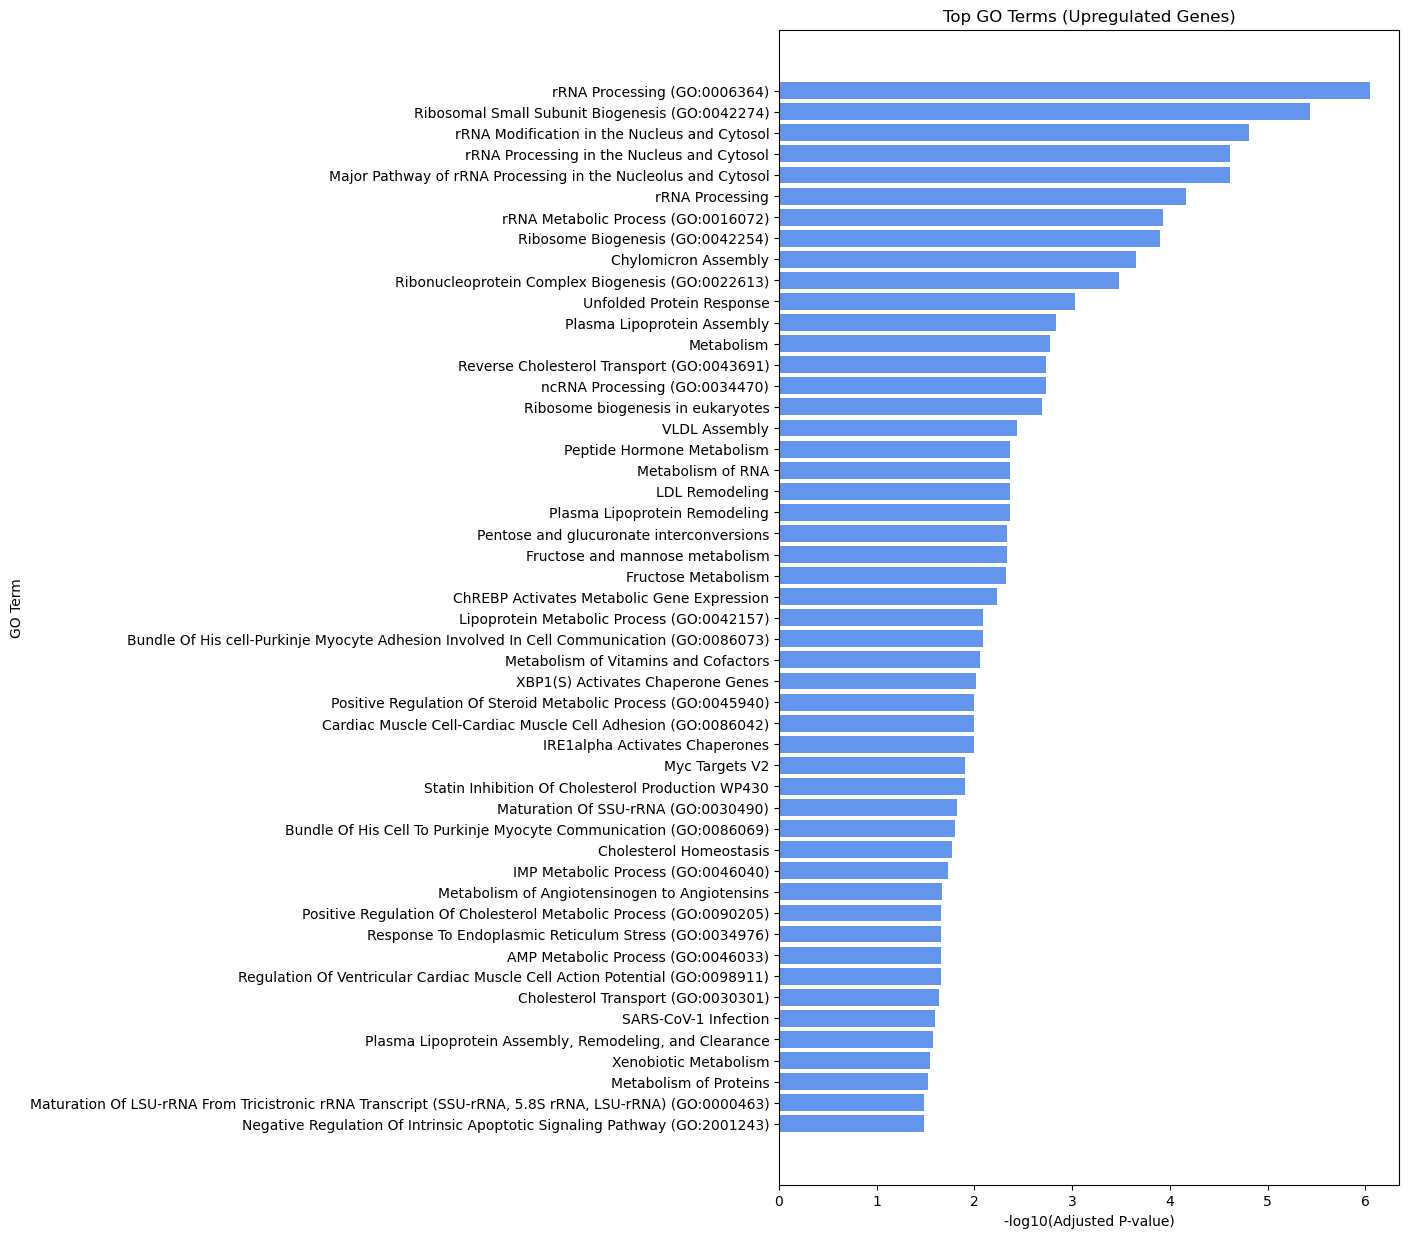

In [45]:
dbs = ['MSigDB_Hallmark_2020','GO_Biological_Process_2023',
       #'Reactome_2022',
       'Reactome_Pathways_2024',
       'WikiPathways_2024_Human',
       #'GO_Cellular_Component_2023',
       #'GO_Molecular_Function_2023',
       'KEGG_2021_Human']


# Perform GO enrichment analysis for upregulated genes
go_up = gp.enrichr(gene_list=always_up_in_NvA, 
                   organism='Human',  
                   #background=ryu_meyer_set,
                   gene_sets=dbs,
                   outdir=None)


# Perform GO enrichment analysis for downregulated genes
go_down = gp.enrichr(gene_list=always_down_in_NvA, 
                     organism='Human', 
                     #background=ryu_meyer_set,
                     gene_sets=dbs,
                     outdir=None)

# Convert results into DataFrames
df_up = go_up.results
df_down = go_down.results

# Plot GO terms for upregulated and downregulated genes
plot_go_terms(df_up, "Top GO Terms (Upregulated Genes)", "cornflowerblue")


# Show top GO terms
#print(df_up[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))
#print(df_down[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))

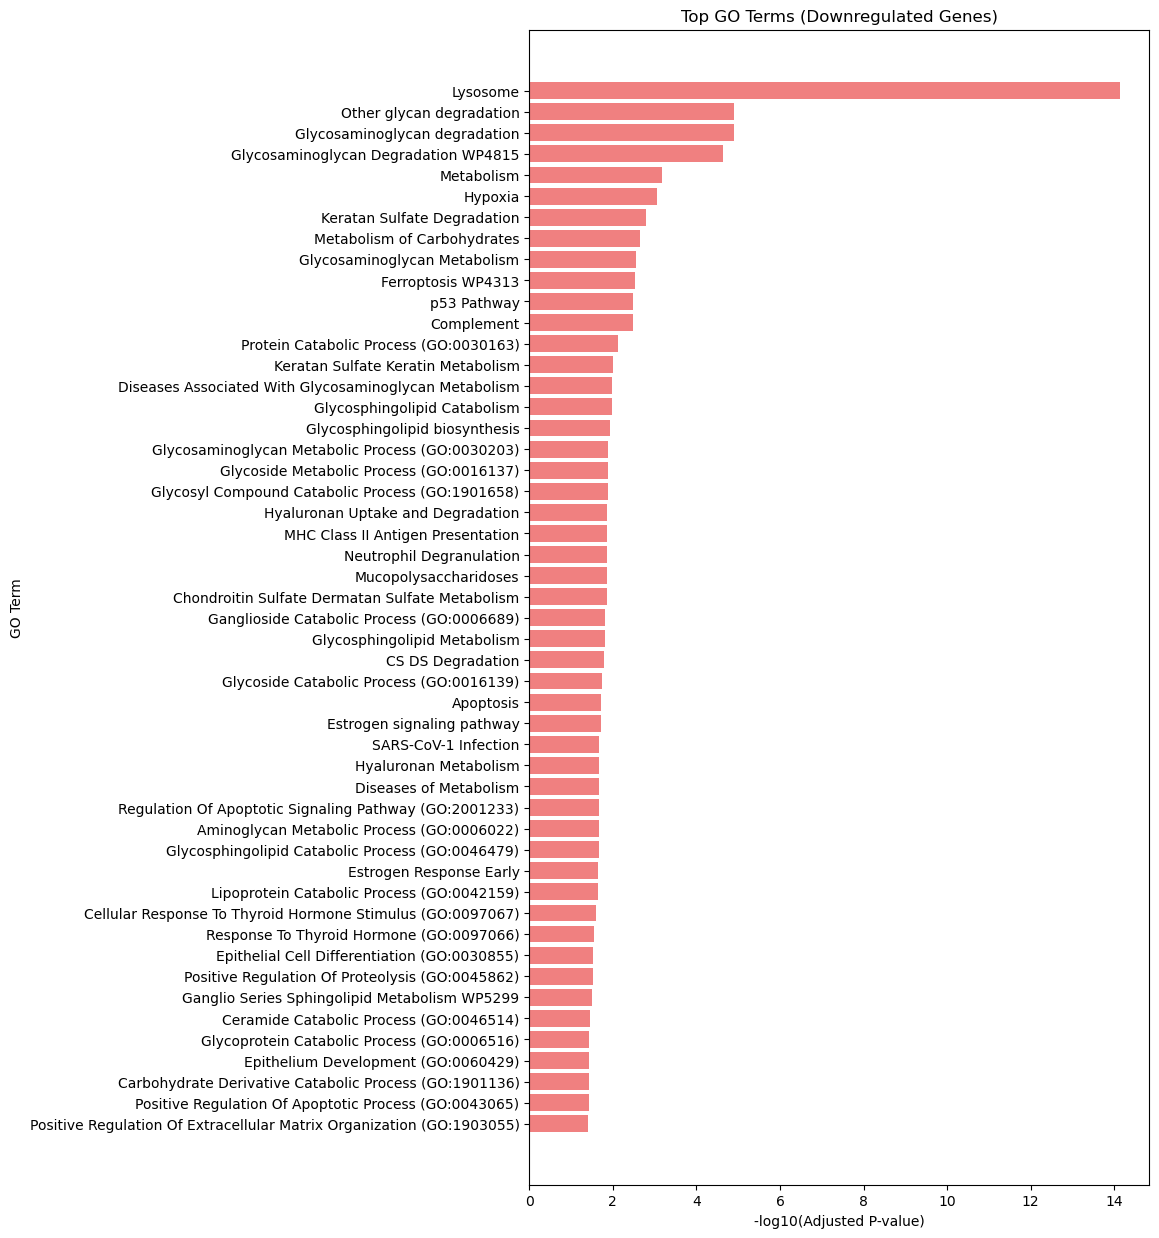

In [46]:
plot_go_terms(df_down, "Top GO Terms (Downregulated Genes)", "lightcoral")

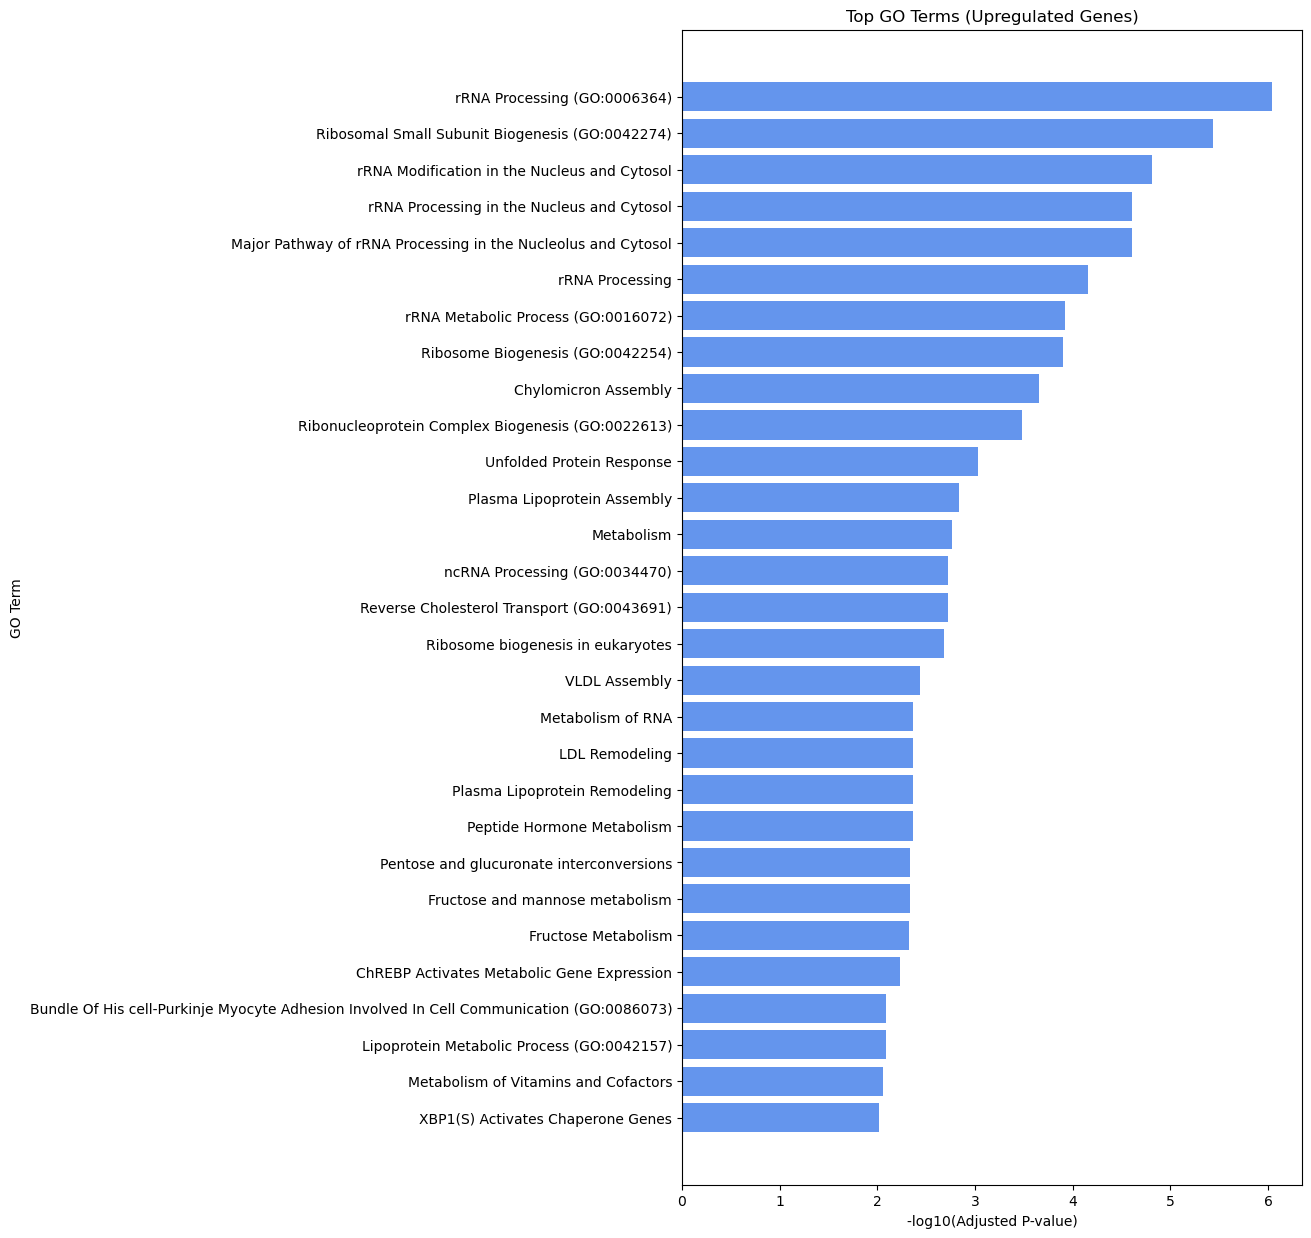

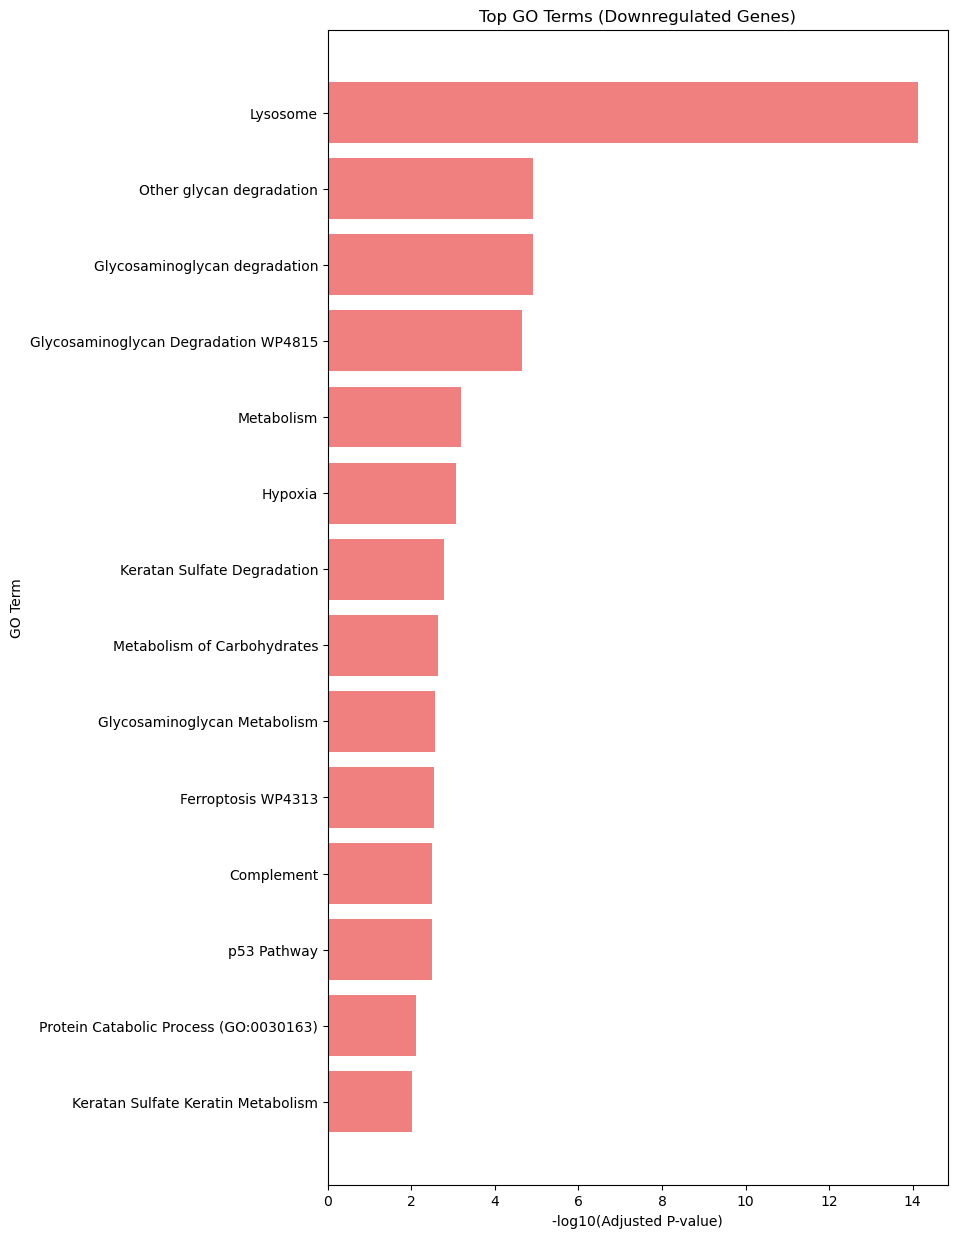

In [47]:
# Plot GO terms for upregulated and downregulated genes
plot_go_terms(df_up[df_up['Adjusted P-value']<0.01], "Top GO Terms (Upregulated Genes)", "cornflowerblue")
plot_go_terms(df_down[df_down['Adjusted P-value']<0.01], "Top GO Terms (Downregulated Genes)", "lightcoral")

In [48]:
with pd.ExcelWriter("./Data/gsea_enr_hepg2abc_always_NvA_results_raw_04302025.xlsx") as writer:
    go_up.results.to_excel(writer, sheet_name="always_up", index=False)
    go_down.results.to_excel(writer, sheet_name="always_down", index=False)

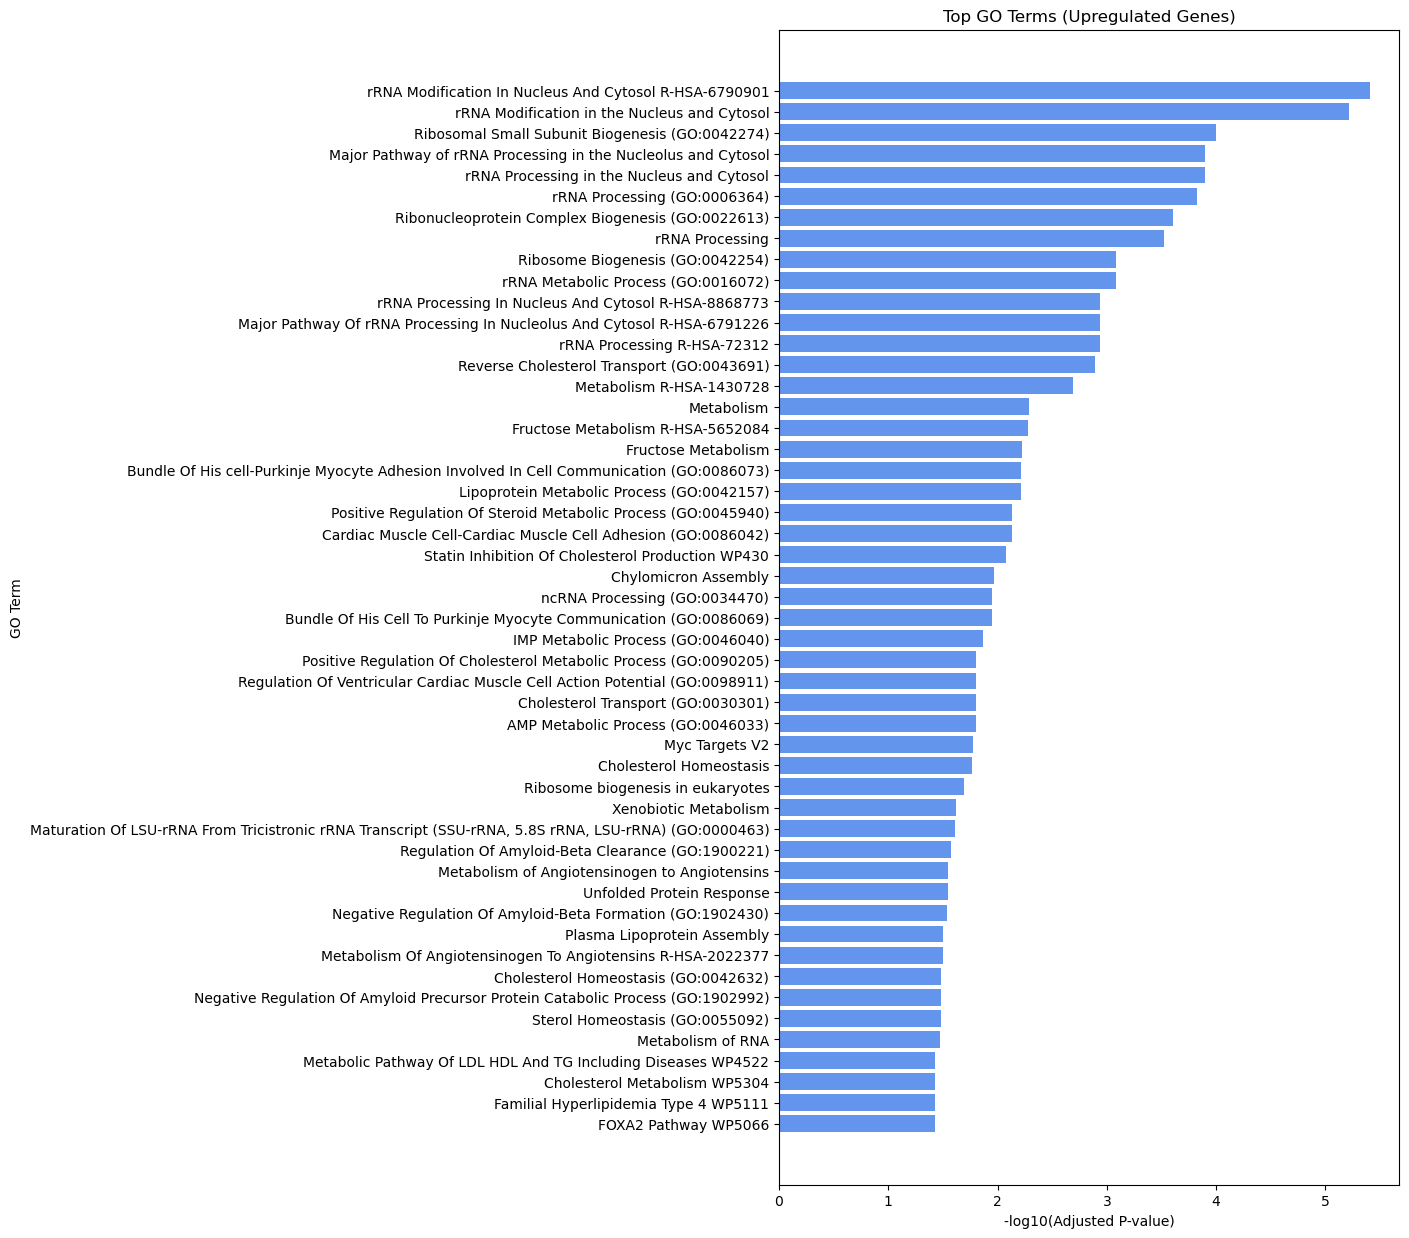

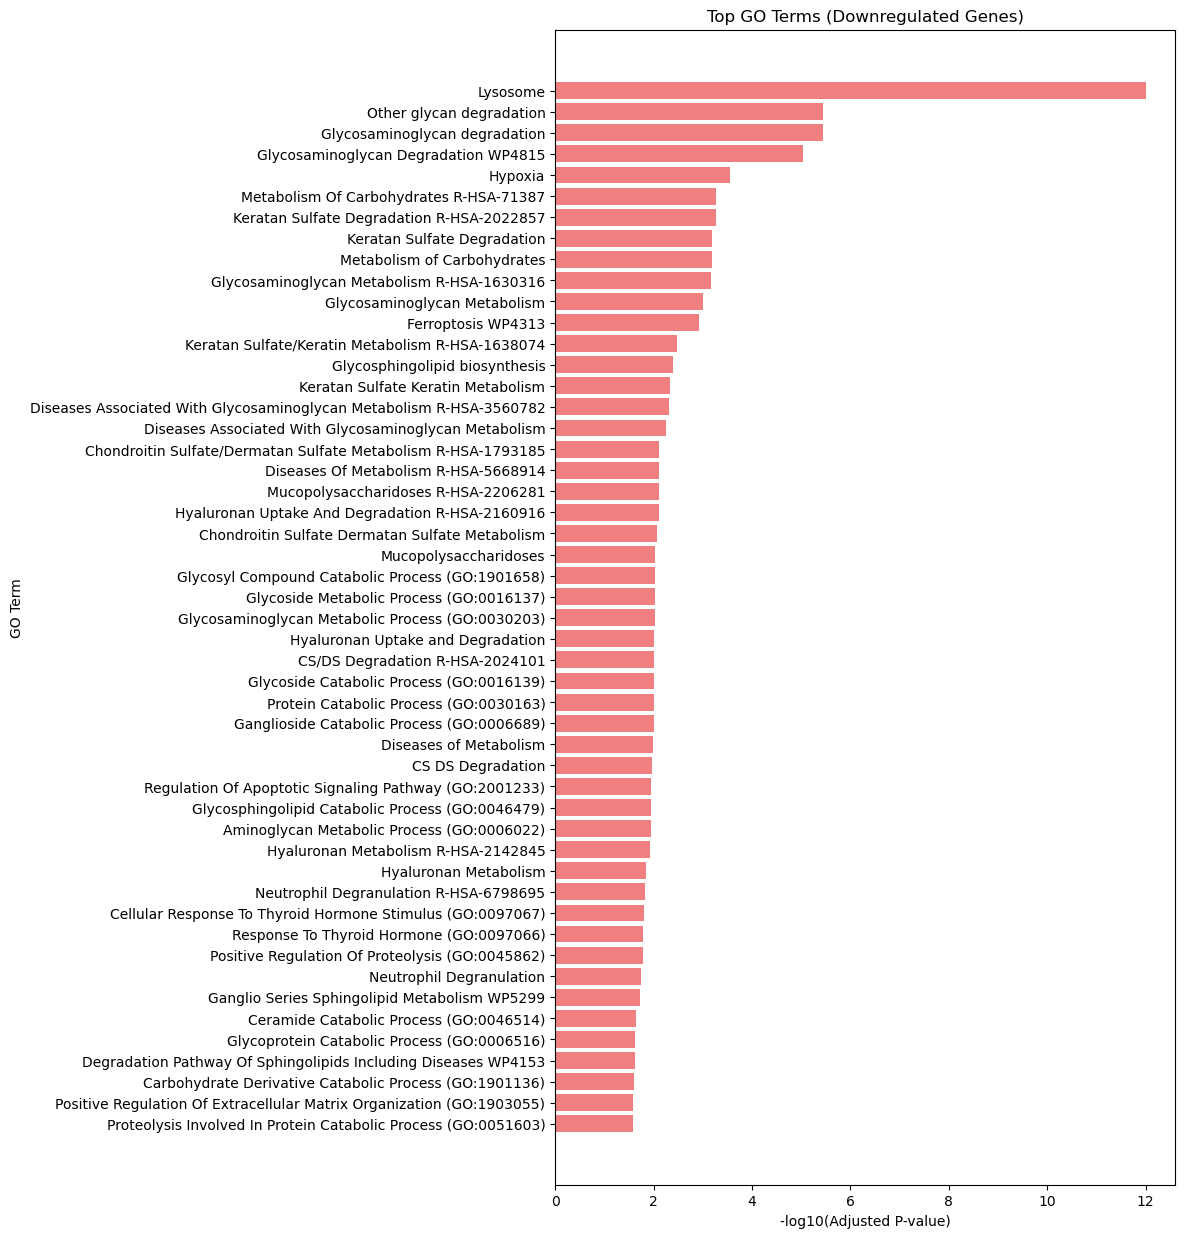

In [51]:
dbs = ['MSigDB_Hallmark_2020','GO_Biological_Process_2023',
       'Reactome_2022',
       'Reactome_Pathways_2024',
       'WikiPathways_2024_Human',
       #'GO_Cellular_Component_2023',
       #'GO_Molecular_Function_2023',
       'KEGG_2021_Human']


# Perform GO enrichment analysis for upregulated genes
go_up = gp.enrichr(gene_list=lme3_upregulated_condN, 
                   organism='Human',  
                   #background=ryu_meyer_set,
                   gene_sets=dbs,
                   outdir=None)


# Perform GO enrichment analysis for downregulated genes
go_down = gp.enrichr(gene_list=lme3_downregulated_condN, 
                     organism='Human', 
                     #background=ryu_meyer_set,
                     gene_sets=dbs,
                     outdir=None)

# Convert results into DataFrames
df_up = go_up.results
df_down = go_down.results

# Plot GO terms for upregulated and downregulated genes
plot_go_terms(df_up, "Top GO Terms (Upregulated Genes)", "cornflowerblue")
plot_go_terms(df_down, "Top GO Terms (Downregulated Genes)", "lightcoral")


# Show top GO terms
#print(df_up[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))
#print(df_down[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))

In [78]:
dbs = ['MSigDB_Hallmark_2020','GO_Biological_Process_2023',
       'Reactome_2022',
       'Reactome_Pathways_2024',
       'WikiPathways_2024_Human',
       #'GO_Cellular_Component_2023',
       #'GO_Molecular_Function_2023',
       'KEGG_2021_Human']


# Perform GO enrichment analysis for upregulated genes
go_up = gp.enrichr(gene_list=lme3_upregulated_condNA, 
                   organism='Human',  
                   #background=ryu_meyer_set,
                   gene_sets=dbs,
                   outdir=None)


# Perform GO enrichment analysis for downregulated genes
go_down = gp.enrichr(gene_list=lme3_downregulated_condNA, 
                     organism='Human', 
                     #background=ryu_meyer_set,
                     gene_sets=dbs,
                     outdir=None)

# Convert results into DataFrames
df_up = go_up.results
df_down = go_down.results

# Plot GO terms for upregulated and downregulated genes
plot_go_terms(df_up, "Top GO Terms (Upregulated Genes)", "cornflowerblue")
plot_go_terms(df_down, "Top GO Terms (Downregulated Genes)", "lightcoral")

# Show top GO terms
#print(df_up[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))
#print(df_down[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))

Exception: Error sending gene list, try again later

In [74]:
dbs = ['MSigDB_Hallmark_2020','GO_Biological_Process_2023',
       'Reactome_2022',
       'Reactome_Pathways_2024',
       'WikiPathways_2024_Human',
       #'GO_Cellular_Component_2023',
       #'GO_Molecular_Function_2023',
       'KEGG_2021_Human']


# Perform GO enrichment analysis for upregulated genes
go_up = gp.enrichr(gene_list=lme3_upregulated_condAN, 
                   organism='Human',  
                   #background=ryu_meyer_set,
                   gene_sets=dbs,
                   outdir=None)


# Perform GO enrichment analysis for downregulated genes
go_down = gp.enrichr(gene_list=lme3_downregulated_condAN, 
                     organism='Human', 
                     #background=ryu_meyer_set,
                     gene_sets=dbs,
                     outdir=None)

# Convert results into DataFrames
df_up = go_up.results
df_down = go_down.results

# Plot GO terms for upregulated and downregulated genes
plot_go_terms(df_up, "Top GO Terms (Upregulated Genes)", "cornflowerblue")
plot_go_terms(df_down, "Top GO Terms (Downregulated Genes)", "lightcoral")

# Show top GO terms
#print(df_up[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))
#print(df_down[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))

Exception: Error sending gene list, try again later

In [ ]:
with pd.ExcelWriter("./Data/gsea_enr_hepg2abc_AN_results_raw_04302025.xlsx") as writer:
    go_up.results.to_excel(writer, sheet_name="upAN", index=False)
    go_down.results.to_excel(writer, sheet_name="downAN", index=False)

# Manual Edits

In [66]:
df_manual_always_up = pd.read_excel("./Data/gsea_enr_hepg2abc_always_NvA_results_manualedits_04302025.xlsx", sheet_name="always_up")
df_manual_always_down = pd.read_excel("./Data/gsea_enr_hepg2abc_always_NvA_results_manualedits_04302025.xlsx", sheet_name="always_down")

In [67]:
def plot_go_terms(df, title, color):
    # Select top 20 significant terms
    df = df.sort_values("Adjusted P-value").head(50)
    
    # Plot bar chart
    plt.figure(figsize=(8, 15))
    plt.barh(df['Term'], -np.log10(df['Adjusted P-value']), color=color)
    plt.xlabel("-log10(Adjusted P-value)",fontsize=20)
    plt.ylabel("GO Term",fontsize=20)
    plt.xticks(fontsize=15)

    plt.yticks(fontsize=15)

    plt.title(title,fontsize=20)
    plt.gca().invert_yaxis()  # Flip to show most significant on top
    plt.show()

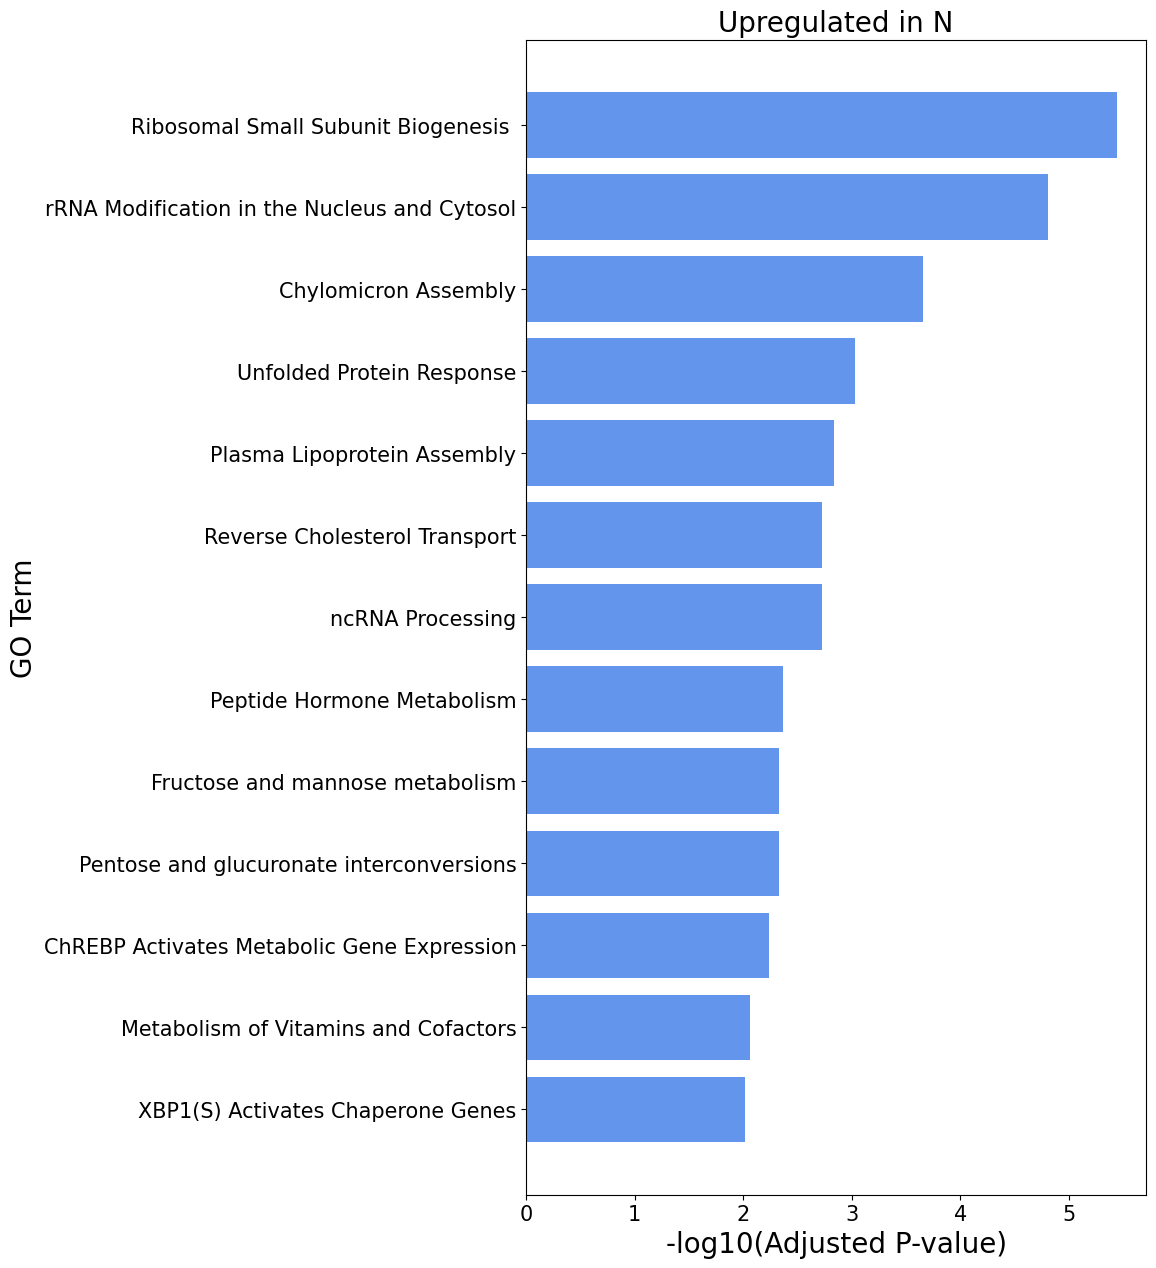

In [68]:
plot_go_terms(df_manual_always_up, "Upregulated in N", "cornflowerblue")

# Add text at the end of each bar

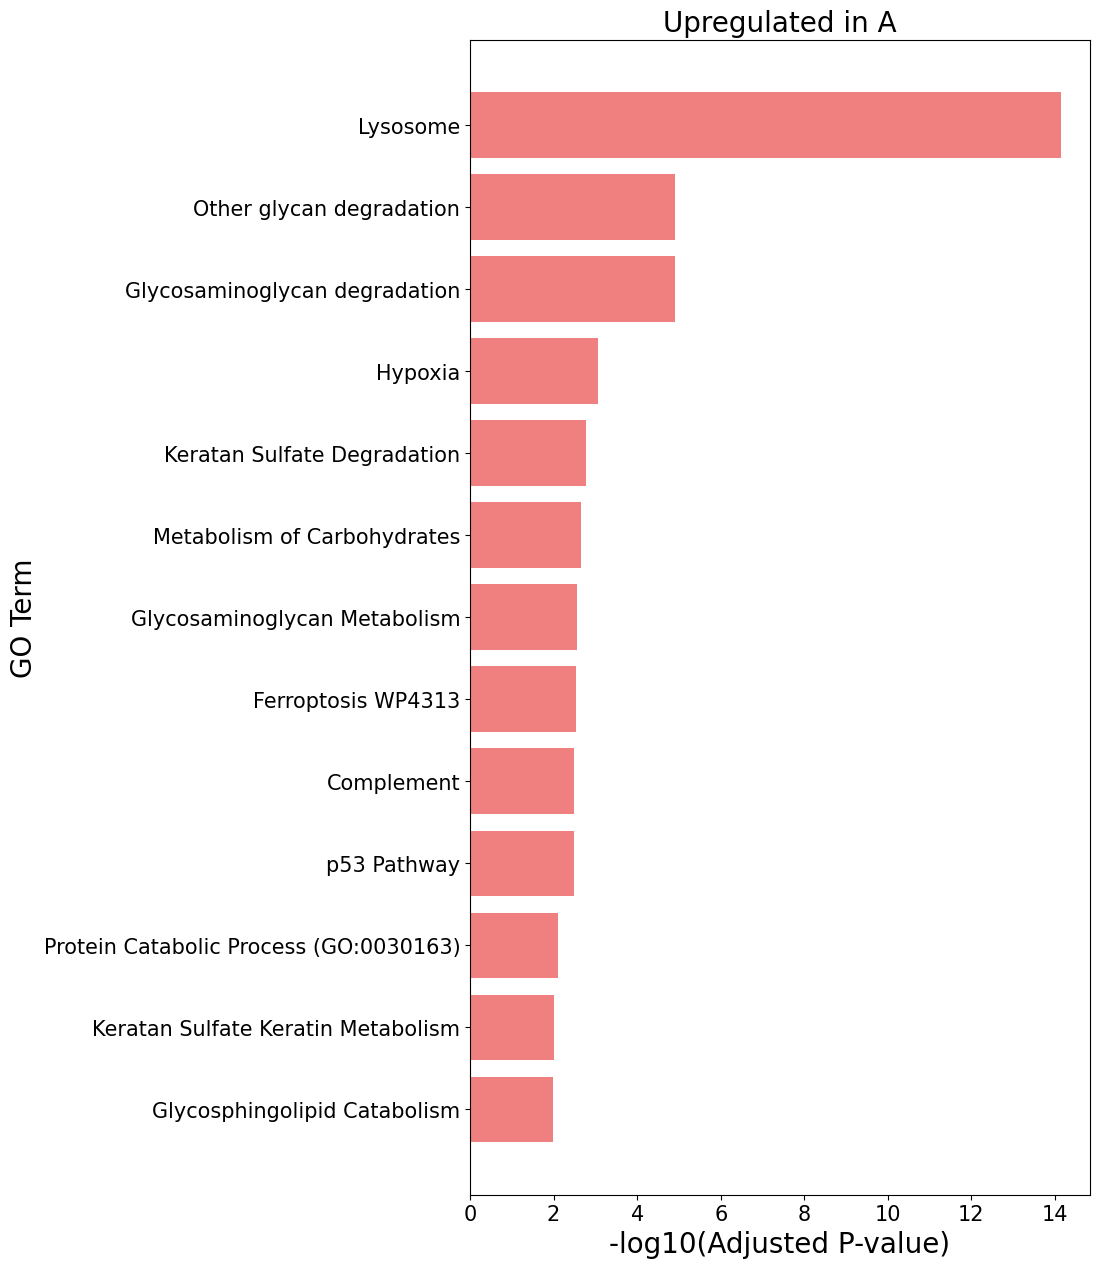

In [69]:
# Plot GO terms for upregulated and downregulated genes
plot_go_terms(df_manual_always_down, "Upregulated in A", "lightcoral")

# Show top GO terms
#print(df_up[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))
#print(df_down[['Term', 'Adjusted P-value', 'Gene_ratio']].head(10))